# Загрузка данных

Загружаю пакеты:

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

# Функция - обрабтное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Загружаю данные из файла, скачанного с Google Analytics:

In [2]:
# Загружаю датасет из своей директории
data = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/ga_transactions.csv", 
                   na_values="NaN", sep = ';')

In [3]:
#Привожу дату в удобный формат
data.date = pd.to_datetime(data.date, format='%Y%m%d')
data.set_index('date', inplace = True)
data.head()

,transactions
date,
2019-06-01,12945
2019-06-02,13354
2019-06-03,22882
2019-06-04,23349
2019-06-05,22454


Данные у меня ограничены мартом 2020. Март я отложу в сторонку и буду проверять на нем качество предсказания. А на остальном фрейме - буду обучать модель.

In [4]:
train = data[:'2020-02']
test = data['2020-03']

Смотрю на данные:

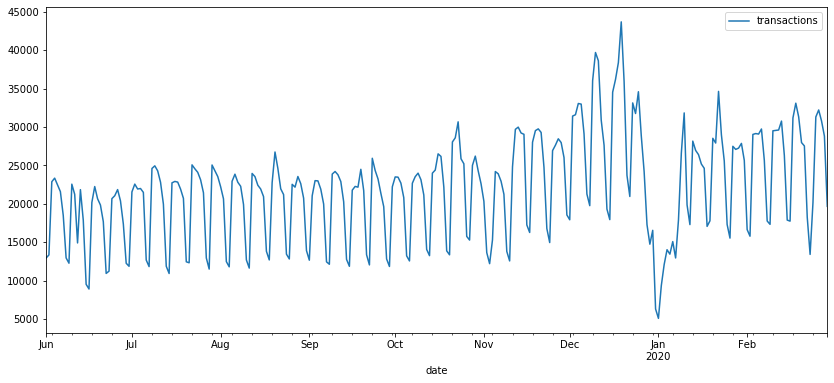

In [5]:
train.plot(figsize = (14,6))

На графике видно, что:
     - Он похож на стационарный
     - Есть недельные колебания (просадка в выходные дни)
     - Есть слабый восходящий тренд
     - Сильные отклонения декабря и января, скорее всего, объясняются праздниками
Проверю временной ряд на стационарность с помощью критерия Дики-Фуллера. В котором тестируется нулевая гипотеза о нестационарности ряда. Уровень значимости будет стандартный - 0.05. И посмотрю на сезонную и трендовую составляющую временного ряда:

Критерий Дики-Фуллера: p=0.108389


<Figure size 864x576 with 0 Axes>

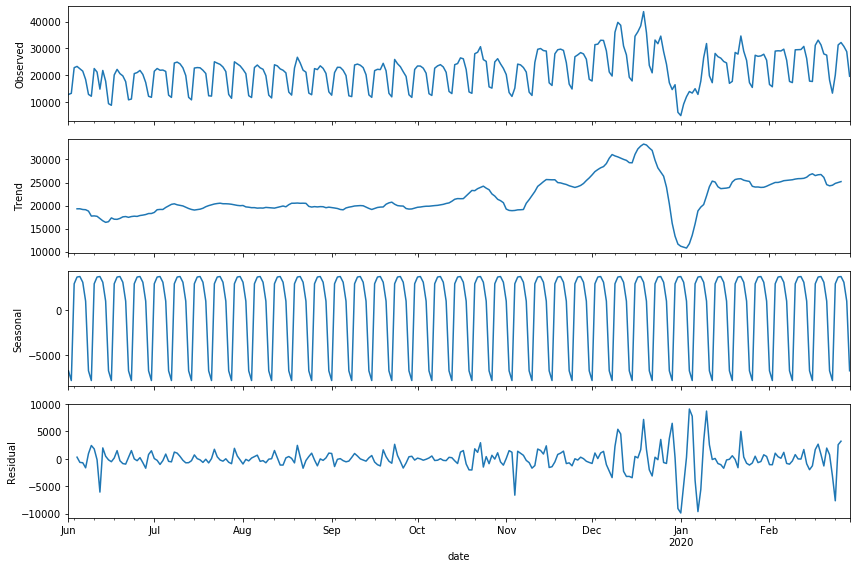

In [6]:
plt.figure(figsize(12,8))
g = sm.tsa.seasonal_decompose(train.transactions).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions)[1])

Какие выводы можно сделать?
1. Критерий Дики-Фуллера не отвергает нулевую гипотезу о нестационарности ряда. Это не хорошо.
2. На графиках виден тренд, ожидание которого отлично от нуля
3. Ряд имеет ярко выраженную сезонность (недельную)
4. Остатки модели похожи на белый шум (случайное блуждание) - это очень хорошо.

Итак, у нас есть сезонность, тренд и нестационарность. От этого всего нужно избавиться. Сезонность регулируется сезонными параметрами ARIMA, а от тренда буду избавляться с помощью дифференцирования. Но для начала использую еще один трюк - сглаживание дисперсии, который должен положительно сказаться на стационарности. По остаткам модели видно, что в декабре и январе дисперсию сильно расшатало - нужно ее успокоить.

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.798654
Критерий Дики-Фуллера: p=0.105928


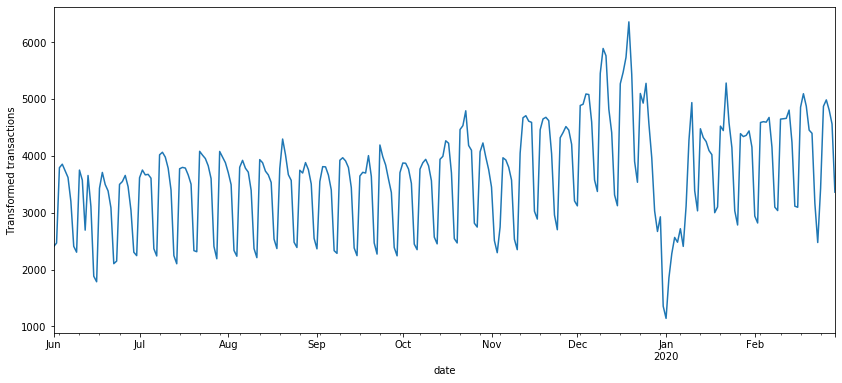

In [7]:
pd.options.mode.chained_assignment = None 

train['transactions_box'], lmbda = stats.boxcox(train.transactions)
plt.figure(figsize(14,6))
train.transactions_box.plot()
plt.ylabel(u'Transformed transactions')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions_box)[1])

Трюк не сработал - такое бывает)  Критерий Дики-Фуллера не сильно изменился и параметр Бокса-Кокса близок к 1. (коеф = 1, означает исходный ряд). Можно не применять сглаживание, но в учебных целях - сделаю с ним.

## Дифференцирование ряда

Следующий этап - это дифференцирование, которое поможет найти параметры p и P. Начну с сезонного дифференцирования. В моем случае сезон это 7 дней. Вот от каждого дня я отниму его значение 7 дней назад и посмотрю что из этого получится:

Критерий Дики-Фуллера: p=0.000901


<Figure size 864x576 with 0 Axes>

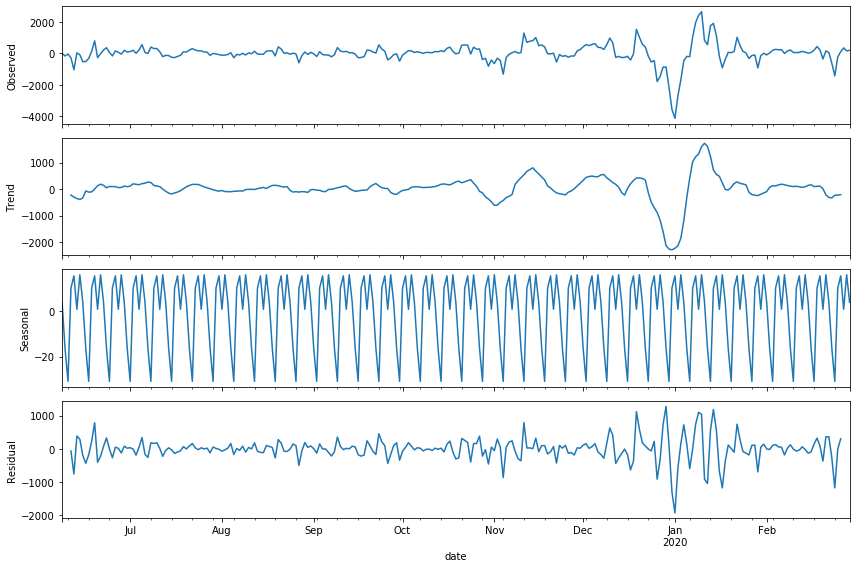

In [8]:
train['transactions_diff'] = train.transactions_box - train.transactions_box.shift(7) 
plt.figure(figsize(12,8))
g = sm.tsa.seasonal_decompose(train.transactions_diff[7:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions_diff[7:])[1])

Not bad.

Критерий Д-Ф опровергает гипотезу о нестационарности. Тренд в нуле. Остатки случайны. Все изъяны ряда вылечены. Но так бывает не всегда, если не удается добиться стационарности, после сезонного дифференцирования можно применить обычное - первого порядка: из уже дифференцированного ряда вычесть предыдущее значение. Но, чем меньше дифференцируешь - тем ближе ты подгоняешь моделируемый ряд к реальному, поэтому не нужно увлекаться.

Критерий Дики-Фуллера: p=0.000000


<Figure size 864x576 with 0 Axes>

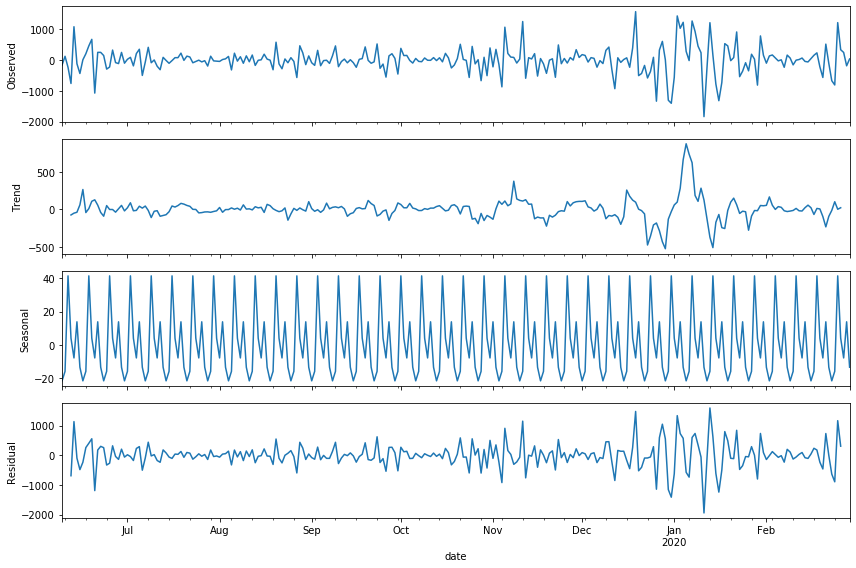

In [9]:
train['transactions_diff2'] = train.transactions_diff - train.transactions_diff.shift(1) 
plt.figure(figsize(12,8))
g = sm.tsa.seasonal_decompose(train.transactions_diff2[8:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.transactions_diff2[8:])[1])

Критерий Д-Ф стал еще лучше, что ожидаемо. Теперь пришло время взглянуть на корреляции между лагами и найти приближенно начальные параметры для перебора.

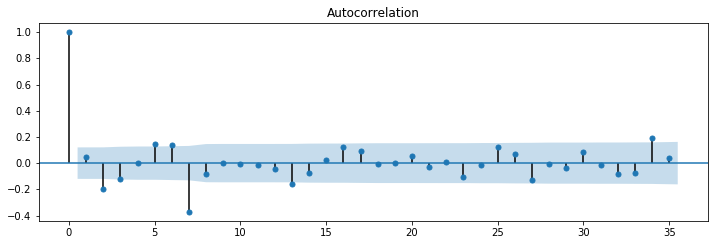

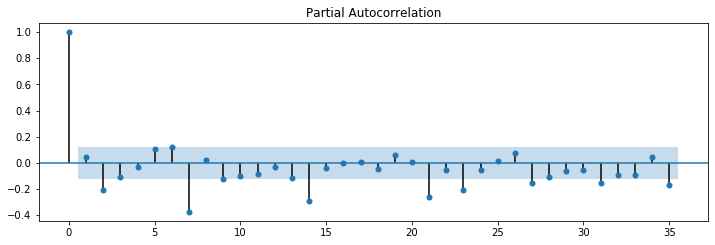

In [10]:
plt.figure(figsize(12,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train.transactions_diff2[8:].values.squeeze(), lags=35, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train.transactions_diff2[8:].values.squeeze(), lags=35, ax=ax)
pylab.show()

In [11]:
Qs = range(0, 2)
qs = (2,3,5,6,13)
Ps = range(0, 4)
ps = (2,6,23,27,31)
D=1
d=1

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

200

In [13]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
i = 0
for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.transactions_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
1    (2, 2, 0, 1)  3848.979018
9    (2, 3, 0, 1)  3849.058171
11   (2, 3, 1, 1)  3860.798094
15   (2, 3, 3, 1)  3862.711358
33  (2, 13, 0, 1)  3863.520277


Посмотрю на характеристики лучшей модели:

In [15]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                  transactions_box   No. Observations:                  274
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 7)   Log Likelihood               -1918.490
Date:                           Thu, 07 May 2020   AIC                           3848.979
Time:                                   08:59:35   BIC                           3870.480
Sample:                               06-01-2019   HQIC                          3857.617
                                    - 02-29-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4084      0.032     43.543      0.000       1.345       1.472
ar.L2         -0.8991      0.029    -30.521

Посмотрю на остатки модели:

Критерий Стьюдента: p=0.976579
Критерий Дики-Фуллера: p=0.000000


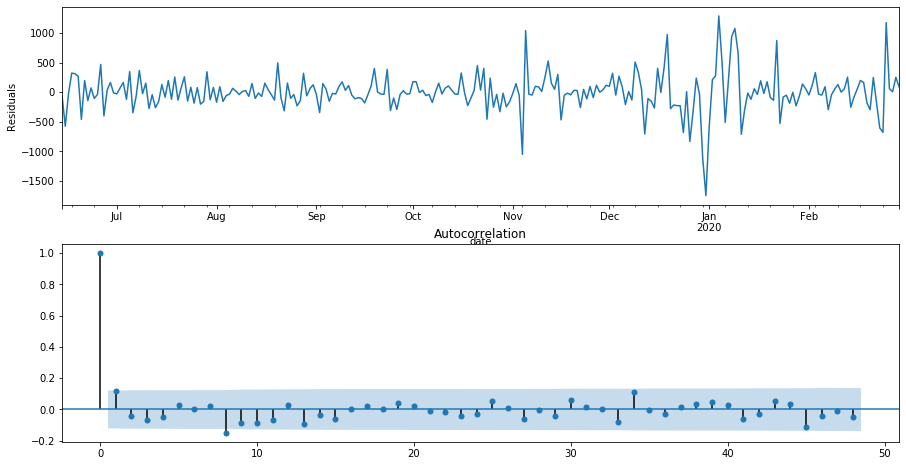

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрю, насколько хорошо модель описывает данные:

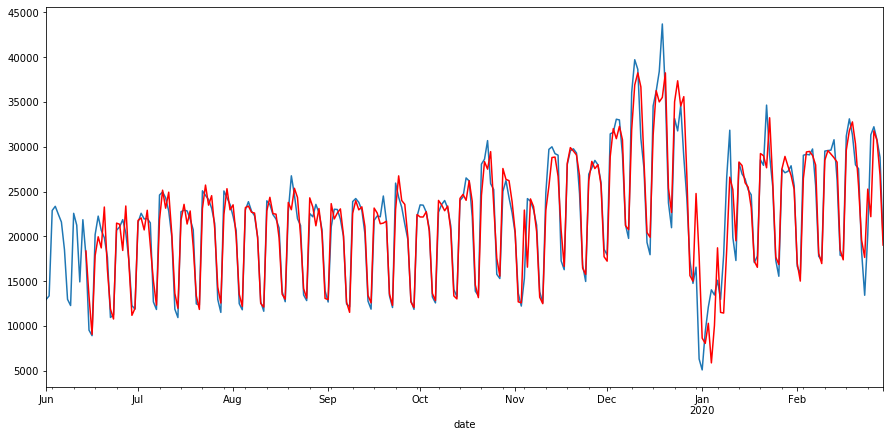

In [17]:
train['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
train.transactions.plot()
train.model[13:].plot(color='r')
pylab.show()

## Прогноз

Спрогнозирую март и сравню с текущими значениями

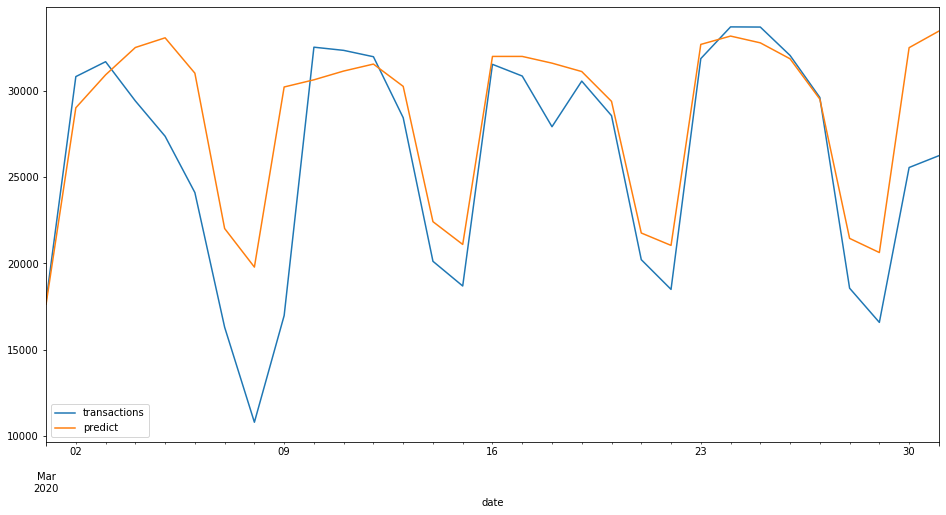

In [18]:
df_pred = pd.DataFrame(round(invboxcox(best_model.get_forecast(steps=31).predicted_mean, lmbda)).astype('int'), 
                       columns = ['predict'])
test.merge(df_pred, left_index=True, right_index=True, how = 'left').plot(figsize = (16,8))

In [20]:
print('Прогноз:',df_pred.predict.sum())
print('Фактические значения:',test.transactions.sum())

Прогноз: 879874
Фактические значения: 805144
